Run the cell below to import all necessary libraries.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ,QuantumCircuit, Aer, transpile, execute
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.providers.ibmq import least_busy
import warnings
warnings.filterwarnings("ignore")
print("Libraries imported successfully")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Libraries imported successfully


Here I solved the problem of comparing two integers for,
 - *positive and negative numbers*
 - *less than 16 greater than -16* (uses about 30 qubits, which is a limitation when simulating on a regular classical computer)
 
I used grovers search and followed [[1]](https://www.educative.io/answers/what-is-a-quantum-binary-comparator)[[2]](https://www.researchgate.net/publication/228574906) resources as a guide.


In [198]:
def find_the_largest_number(number_1,number_2):
    
     """
     number_1 : integer value that is the first parameter to the function,
     number_2 : integer value that is the second parameter to the function.
     Return the largest number between number_1 and number_2
     """
     # absolute value of the integers
     e,f=abs(number_1),abs(number_2)
     # use a framework that works with quantum circuits, qiskit, cirq, pennylane, etc.
     # consider print your quantum circuit
     # Here I converted the integers to binary string.
     a=bin(e)[2:]
     b=bin(f)[2:]
        
     # Here I calculated the length of the largest binary number recursively
     # elif clause below checks if there is a string of.length 2 and not 2 and the  combination (2,1),(1,2) to avoid recursion overflow
     c,d=len(a),len(b)
     if c==d:
         n=c
     elif (int(c==2)+int(d==2))%2==1 and c+d==3:
         n=2
     else:
         n,_=find_the_largest_number(c,d)
        
#      n=max(c,d)
     # Here I make the two binary string of same size.
     a=a.zfill(n)
        
     b=b.zfill(n)
    
     # The function UC(qc,l) below does the bitwise comparison. If the first numer is bigger, the state of 2nd and 3rd
     #  qubit will be |10>, if second number is bigger the state will be |01> and if same it will be |00>.
     def UC(qc,l):
          qc.x(5*l+1)
          qc.ccx(5*l,5*l+1,5*l+2)
          qc.x([5*l,5*l+1])
          qc.ccx(5*l,5*l+1,5*l+3)
          qc.x(5*l)
    
     # The function U(qc,a,b) is just the generalization of the previous bitwise comparator circuit. Here the output
     #  will be the result to The two n bit binary string comparison.
     def U(qc,n,a,b):
          for i in range(n):
               if a[i]=="1":
                    qc.x(5*i)
               if b[i]=="1":
                    qc.x(5*i+1)
               UC(qc,i)
          for j in range(n-1,0,-1):
               qc.x([5*j-3,5*j-2])
               qc.ccx(5*j-3,5*j-2,5*j-1)
               qc.x([5*j-3,5*j-2])
               qc.ccx(5*j+2,5*j-1,5*j-3)
               qc.ccx(5*j+3,5*j-1,5*j-2)

     # Here I created a 6*n qubit resister and n classical resister. 
     qc=QuantumCircuit(6*n+2,n)
        
     # Here I prepared the initial search space.
     qc.h(range(6*n-2,6*n-2-n,-1))
        
     # This is a auxiliary qubit to use for phase kickback initialized to |->.
     qc.h(6*n-1)
     qc.z(6*n-1)
    
     # Here U does the classical calculation of the comparator oracle.
     U(qc,n,a,b)
     
     # Manipulate the sign of integers
     qc.cx(2,6*n)
     qc.cx(3,6*n)
     qc.cx(2,6*n+1)
     if number_1<0 and number_2<0:
          qc.cx(6*n,2)
          qc.cx(6*n,3)
     elif number_1>=0 and number_2>=0:
          pass
     else:
          if number_1<0:
              qc.cx(6*n+1,2)
              qc.cx(6*n+1,3)
          else:
              qc.x(6*n+1)
              qc.cx(6*n+1,2)
              qc.cx(6*n+1,3)
              qc.x(6*n+1)
     
     # Here the loop runs for square root of n times for optimal result.
     for _ in range(math.isqrt(n)):

          # This indented part is the phase oracle of grovers search.  
          if True:
              qc.h(6*n-1)
              for i in range(n):
                   if a[i]=="0":
                        qc.x(5*n-1+i)
              qc.mct([2]+list(range(6*n-2,6*n-2-n,-1)),6*n-1)
              for i in range(n):
                   if a[i]=="0":
                        qc.x(5*n-1+i)
              qc.h(6*n-1)
              qc.h(6*n-1)
              for j in range(n):
                   if b[j]=="0":
                        qc.x(5*n-1+j)
              qc.mct([3]+list(range(6*n-2,6*n-2-n,-1)),6*n-1)
              for j in range(n):
                   if b[j]=="0":
                        qc.x(5*n-1+j)
              qc.h(6*n-1)

          # Here indented part is the diffuser operator
          if True:
              qc.h(range(6*n-2,6*n-2-n,-1))
              if n==1:
                   qc.z(6*n-2)
              else:
                   qc.x(range(6*n-2,6*n-2-n,-1))
                   qc.h(6*n-2)
                   qc.mct(list(range(6*n-3,6*n-2-n,-1)),6*n-2)
                   qc.h(6*n-2)
                   qc.x(range(6*n-2,6*n-2-n,-1))
              qc.h(range(6*n-2,6*n-2-n,-1))
     
     # Here I output the result of the solution states to the classical resiters.
     qc.measure(range(6*n-2,6*n-2-n,-1),range(n))
    
     # Here I print the circuit.
     #print(qc)
     # Here I used aer simulator.
     sim=AerSimulator(method='automatic')
    
     # Here I traspiled my quantum circuit to make it compatible 
     # (Convert my gates to equivalent ones that the simulator supports) for my simulator.
     # Then I run(sample) the circuit using the simulator and returned the counts of each possible states.
    
     result=sim.run(transpile(qc,sim)).result().get_counts()
     # print(result)
     # Then I print the bigger number.
     try:
         # here if there is more than or less than 1 number greater than probability 200 it returns number_1 as the ans.
         q=(a for a,i in result.items() if i>200)
         p=int(next(q),2)
         # This part is to adjust with negative numbers.
         p=number_1*(p==e)+number_2*(p==f)
         next(q)
         if number_1==0 and number_2>=0:
             p=number_2
         elif number_2==0 and number_1>=0:
             p=number_1
     except:
         try:
             p
         except:
             p=number_1
     #print("The bigger number is",p)
     return (p,qc)
     

In [ ]:
for i in range(-15,16):
    for j in range(-15,16):
        result,qc=find_the_largest_number(i,j)
        print("(num_1,num_2) (",i,j,") (qu_max,cl_max) (",result,max(i,j),")",result==max(i,j))

{'1110': 61, '1100': 56, '0010': 58, '0000': 73, '1000': 59, '0110': 65, '1101': 70, '1111': 71, '0001': 68, '0111': 51, '0011': 70, '1011': 62, '0100': 71, '1001': 76, '0101': 63, '1010': 50}
(num_1,num_2) ( -15 -15 ) (qu_max,cl_max) ( -15 -15 ) True
{'0010': 30, '0000': 33, '1110': 518, '0110': 34, '1000': 27, '0101': 40, '1001': 31, '1100': 25, '1101': 38, '0001': 31, '1111': 39, '0100': 38, '1010': 36, '0011': 33, '0111': 35, '1011': 36}
14
(num_1,num_2) ( -15 -14 ) (qu_max,cl_max) ( -14 -14 ) True
{'1100': 30, '1011': 32, '0111': 35, '0011': 23, '1101': 512, '1000': 36, '0110': 33, '1110': 30, '1111': 36, '0001': 33, '0010': 39, '0000': 32, '0100': 43, '0101': 47, '1001': 36, '1010': 27}
13
(num_1,num_2) ( -15 -13 ) (qu_max,cl_max) ( -13 -13 ) True
{'0100': 40, '1010': 29, '1100': 516, '0101': 36, '1001': 29, '1110': 43, '1000': 27, '0110': 32, '1101': 28, '0001': 33, '1111': 35, '0010': 32, '0000': 28, '1011': 44, '0111': 42, '0011': 30}
12
(num_1,num_2) ( -15 -12 ) (qu_max,cl_ma

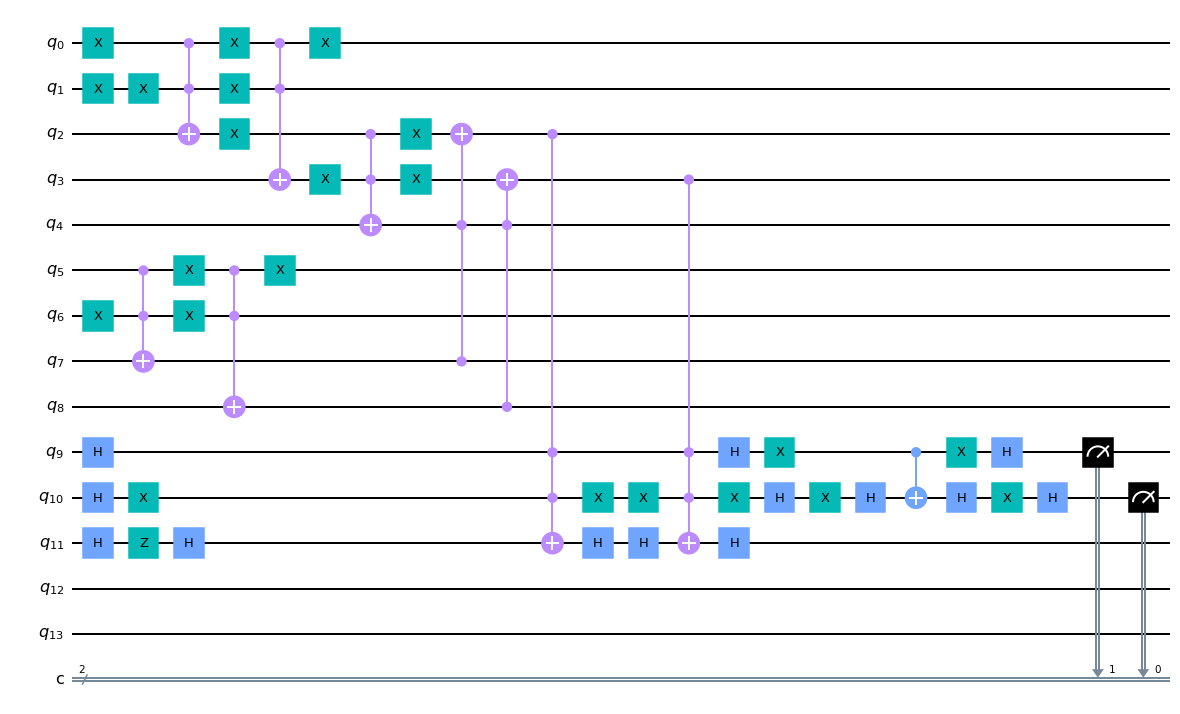

In [154]:
qc.draw(output="mpl")